# Imports & Installs

In [1]:
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler


In [2]:
df = pd.read_csv("amazon-employee-access-challenge/train.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32769 entries, 0 to 32768
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   ACTION            32769 non-null  int64
 1   RESOURCE          32769 non-null  int64
 2   MGR_ID            32769 non-null  int64
 3   ROLE_ROLLUP_1     32769 non-null  int64
 4   ROLE_ROLLUP_2     32769 non-null  int64
 5   ROLE_DEPTNAME     32769 non-null  int64
 6   ROLE_TITLE        32769 non-null  int64
 7   ROLE_FAMILY_DESC  32769 non-null  int64
 8   ROLE_FAMILY       32769 non-null  int64
 9   ROLE_CODE         32769 non-null  int64
dtypes: int64(10)
memory usage: 2.5 MB


# Análise de tratamento de dados

In [3]:
df.shape

(32769, 10)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32769 entries, 0 to 32768
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   ACTION            32769 non-null  int64
 1   RESOURCE          32769 non-null  int64
 2   MGR_ID            32769 non-null  int64
 3   ROLE_ROLLUP_1     32769 non-null  int64
 4   ROLE_ROLLUP_2     32769 non-null  int64
 5   ROLE_DEPTNAME     32769 non-null  int64
 6   ROLE_TITLE        32769 non-null  int64
 7   ROLE_FAMILY_DESC  32769 non-null  int64
 8   ROLE_FAMILY       32769 non-null  int64
 9   ROLE_CODE         32769 non-null  int64
dtypes: int64(10)
memory usage: 2.5 MB


In [5]:
df.head()

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,39353,85475,117961,118300,123472,117905,117906,290919,117908
1,1,17183,1540,117961,118343,123125,118536,118536,308574,118539
2,1,36724,14457,118219,118220,117884,117879,267952,19721,117880
3,1,36135,5396,117961,118343,119993,118321,240983,290919,118322
4,1,42680,5905,117929,117930,119569,119323,123932,19793,119325


## Identificação e tratamento de valores faltantes

In [6]:
df.isnull().sum()

ACTION              0
RESOURCE            0
MGR_ID              0
ROLE_ROLLUP_1       0
ROLE_ROLLUP_2       0
ROLE_DEPTNAME       0
ROLE_TITLE          0
ROLE_FAMILY_DESC    0
ROLE_FAMILY         0
ROLE_CODE           0
dtype: int64

Como não há valores faltantes não é necessário fazer o tratamento de nulos.

## Duplicatas

In [7]:
df.duplicated().sum()

0

Como não há valores duplicados não é necessário fazer o tratamento de nulos.

## Outliers

In [8]:
df['RESOURCE'].value_counts()

RESOURCE
4675      839
79092     484
75078     409
25993     409
3853      404
         ... 
104693      1
76459       1
20738       1
44801       1
32147       1
Name: count, Length: 7518, dtype: int64

In [9]:
type(df['RESOURCE'].value_counts())

pandas.core.series.Series

In [10]:
df['RESOURCE'].value_counts().values

array([839, 484, 409, ...,   1,   1,   1], dtype=int64)

In [11]:
df_counts = df['RESOURCE'].value_counts().reset_index()
df_counts.columns = ['RESOURCE', 'count']

# Análise exploratória de Dados

In [13]:
df.sample(10)

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
6727,1,74463,17652,120864,120865,171098,118702,194774,118704,118705
26379,0,33642,53242,117876,117877,117878,118568,179860,19721,118570
19143,1,969,15473,117902,118041,117945,280788,280788,292795,119082
24318,1,3130,40509,117961,118225,118403,119743,141396,3130,119745
4526,1,14570,11987,118006,118007,118008,117879,117897,19721,117880
6850,1,20364,41786,117961,118386,129128,118636,126747,118638,118639
9973,1,34954,58916,117961,118327,118391,118321,117906,290919,118322
7330,1,4675,8164,117961,118327,120685,118841,166363,118643,118843
16429,1,17308,4031,117961,118300,120026,118422,239205,118424,118425
32426,1,18913,92071,117929,117930,117884,117879,117886,19721,117880


# Transformação & Feature Engineering

In [31]:
def agrupa(df, coluna):
    df1 = df.groupby(coluna)['ACTION'].sum().reset_index()
    df1.rename(columns={'ACTION': '1s'}, inplace=True)

    df2 = df.groupby(coluna)['ACTION'].size().reset_index()
    df2.rename(columns={'ACTION': 'Total'}, inplace=True)
    
    return df1, df2



def transforma(df, coluna):
    df1, df2 = agrupa(df, coluna)

    df_merged = pd.merge(df1, df2, on=coluna, how="inner")
    df_merged['taxa_aceite'] = df_merged['1s'] / df_merged['Total']

    dict_aceite = dict(zip(df_merged[coluna],df_merged['taxa_aceite']))

    dict_total = dict(zip(df_merged[coluna],df_merged['Total']))

    return dict_aceite, dict_total


def aplica(df, coluna, dict_aceite, dict_total):
    
    df[coluna+'_taxa_aceite'] = df[coluna].map(dict_aceite)

    df[coluna+'_total'] = df[coluna].map(dict_total)



def transforma_df(df):
    colunas = list(df.columns)
    colunas.remove('ACTION')
    
    for coluna in colunas:
        dict_aceite, dict_total = transforma(df, coluna)
        aplica(df, coluna, dict_aceite, dict_total)

    df.drop(columns=colunas, inplace=True)

    y = df.pop('ACTION')
    X = df

    scaler = MinMaxScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X), columns = X.columns)

    return X_scaled, y
# df[coluna] == 3853 -> 0.985149

In [37]:
df = pd.read_csv("amazon-employee-access-challenge/train.csv")

In [38]:
X, y = transforma_df(df)

rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)

X_resampled, y_resampled = rus.fit_resample(X, y)

print(f'Resampled dataset shape %s' % Counter(y_resampled))

Resampled dataset shape Counter({0: 1897, 1: 1897})


# Análise Exploratória de Dados

In [48]:
X_resampled.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3794 entries, 5 to 32630
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   RESOURCE_taxa_aceite          3794 non-null   float64
 1   RESOURCE_total                3794 non-null   float64
 2   MGR_ID_taxa_aceite            3794 non-null   float64
 3   MGR_ID_total                  3794 non-null   float64
 4   ROLE_ROLLUP_1_taxa_aceite     3794 non-null   float64
 5   ROLE_ROLLUP_1_total           3794 non-null   float64
 6   ROLE_ROLLUP_2_taxa_aceite     3794 non-null   float64
 7   ROLE_ROLLUP_2_total           3794 non-null   float64
 8   ROLE_DEPTNAME_taxa_aceite     3794 non-null   float64
 9   ROLE_DEPTNAME_total           3794 non-null   float64
 10  ROLE_TITLE_taxa_aceite        3794 non-null   float64
 11  ROLE_TITLE_total              3794 non-null   float64
 12  ROLE_FAMILY_DESC_taxa_aceite  3794 non-null   float64
 13  ROLE_FA

In [49]:
X_resampled['RESOURCE_taxa_aceite'].describe()

count    3794.000000
mean        0.798781
std         0.292024
min         0.000000
25%         0.750000
50%         0.933333
75%         0.996424
max         1.000000
Name: RESOURCE_taxa_aceite, dtype: float64

<Axes: xlabel='RESOURCE_taxa_aceite'>

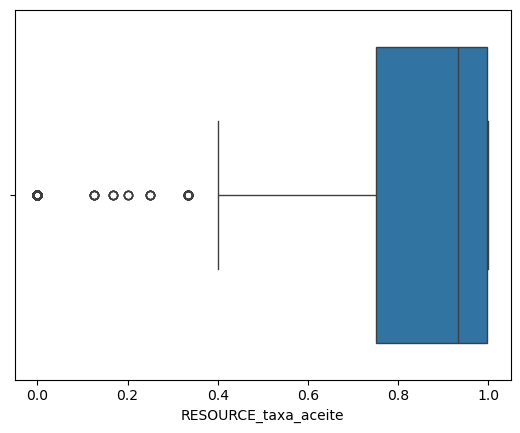

In [50]:
sns.boxplot(data=X_resampled, x='RESOURCE_taxa_aceite')

## Análise Univariada das Features

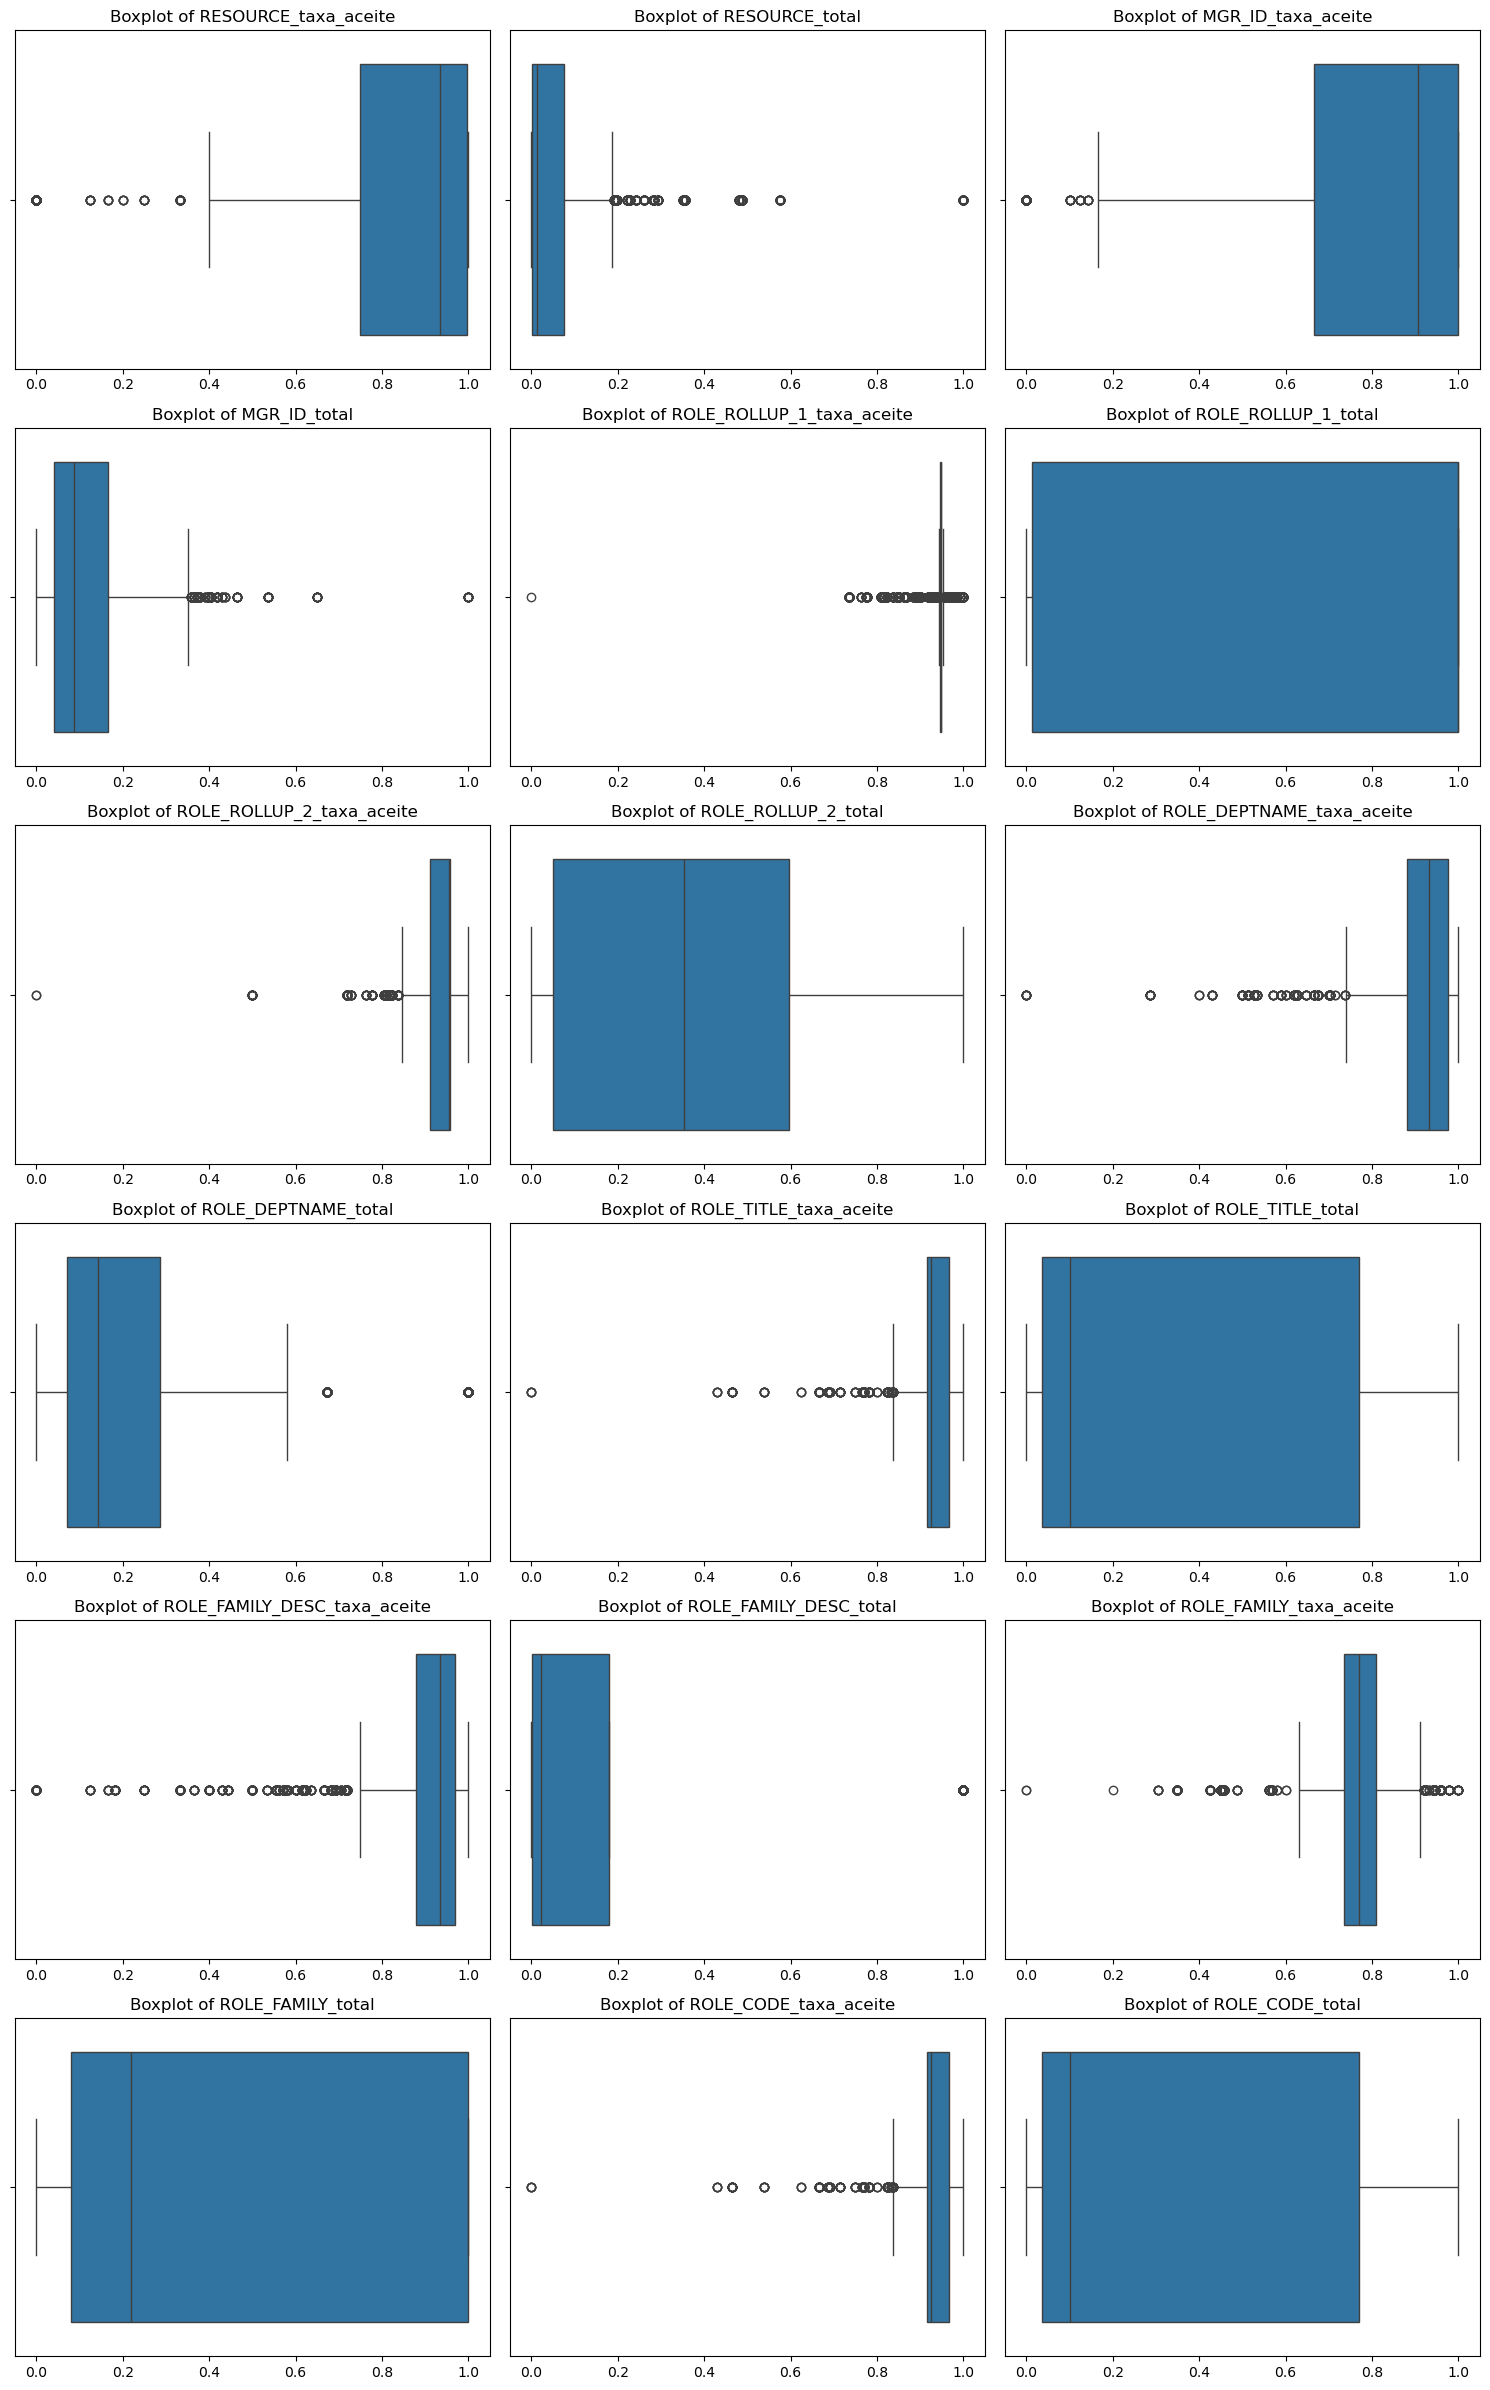

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt
import math

# Get column names
colunas = list(X_resampled.columns)
n_cols = 3  # Number of columns in the grid
n_rows = math.ceil(len(colunas) / n_cols)

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
axes = axes.flatten()  # Flatten in case it's 2D

for idx, coluna in enumerate(colunas):
    # Print statistics
    # print(f"\nStatistics for: {coluna}")
    # print(X_resampled[coluna].describe())
    
    # Create boxplot in subplot
    sns.boxplot(data=X_resampled, x=coluna, ax=axes[idx])
    axes[idx].set_title(f'Boxplot of {coluna}')
    axes[idx].set_xlabel('')

# Hide empty subplots if any
for idx in range(len(colunas), len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.show()

## Análise Bivariada das Features

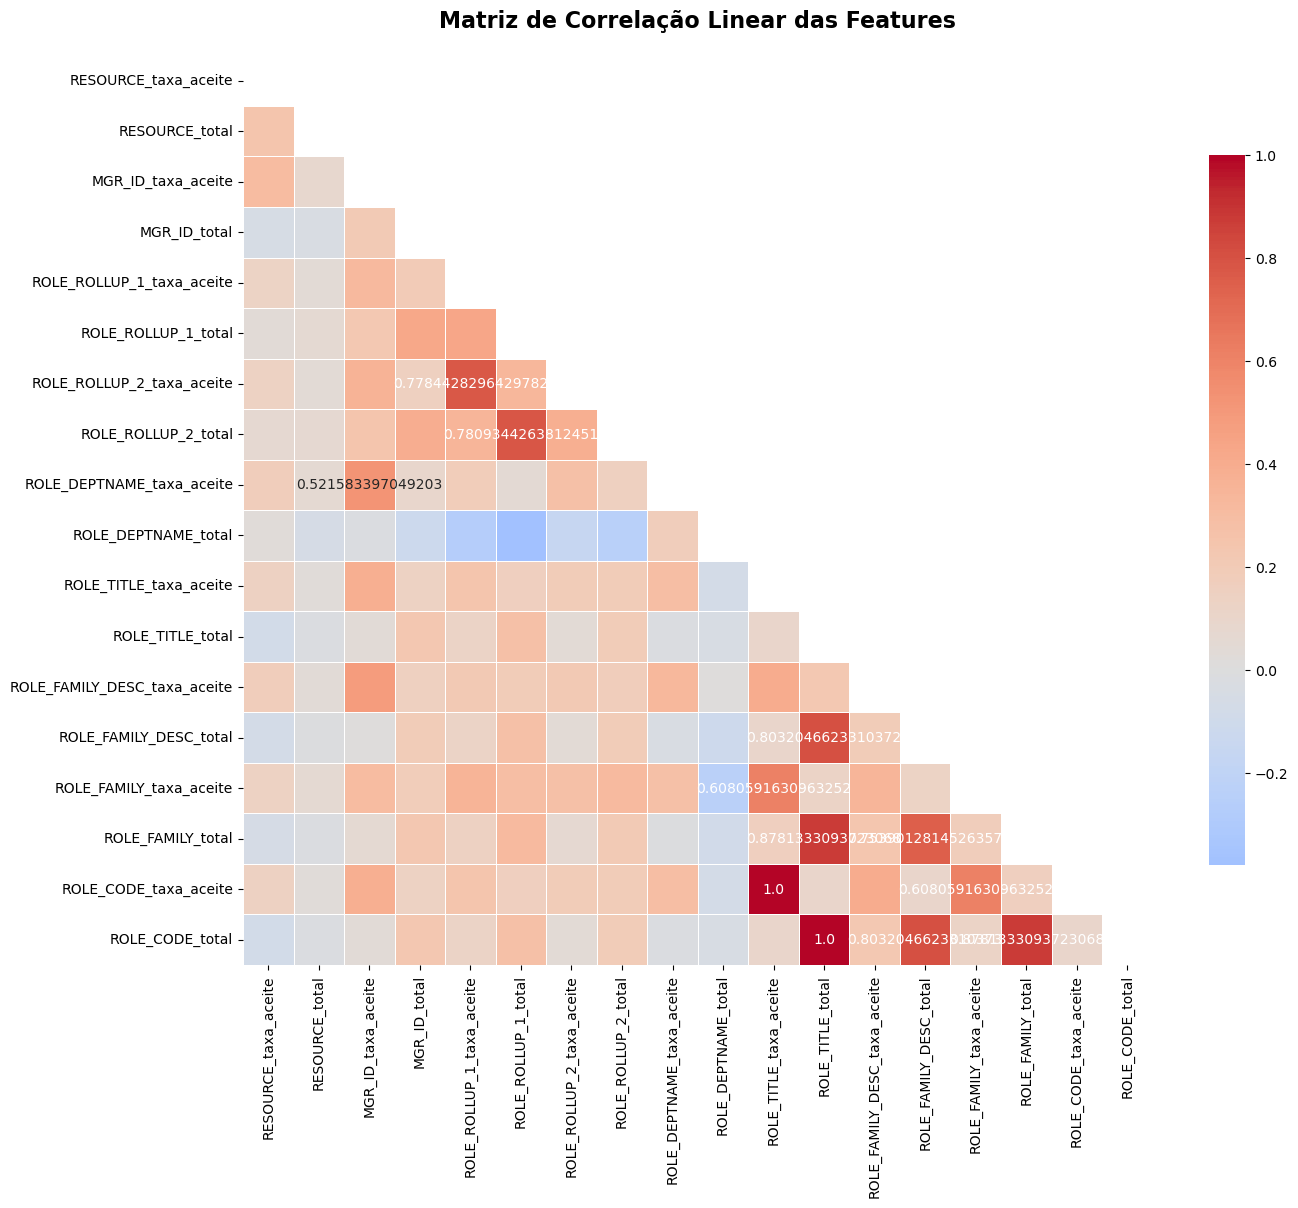

In [68]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate correlation matrix
correlation_matrix = X_resampled.corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Create a custom annotation matrix (only show strong correlations)
threshold = 0.5  # Only annotate correlations above this threshold
annot_matrix = correlation_matrix.copy()
annot_matrix = annot_matrix.where(abs(annot_matrix) > threshold, "")

plt.figure(figsize=(14, 12))

# Create heatmap
sns.heatmap(correlation_matrix,
            mask=mask,
            annot=annot_matrix,      # Custom annotations
            fmt='',                  # No format for empty strings
            cmap='coolwarm',
            center=0,
            square=True,
            linewidths=0.5,
            cbar_kws={"shrink": 0.75})

plt.title(f'Matriz de Correlação Linear das Features', 
          fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

Spearman Correlation Matrix Shape: (18, 18)

Spearman Correlation Matrix (first 5x5):
                           RESOURCE_taxa_aceite  RESOURCE_total  \
RESOURCE_taxa_aceite                   1.000000        0.190542   
RESOURCE_total                         0.190542        1.000000   
MGR_ID_taxa_aceite                     0.564382        0.058872   
MGR_ID_total                           0.034920       -0.182730   
ROLE_ROLLUP_1_taxa_aceite              0.208210       -0.011338   

                           MGR_ID_taxa_aceite  MGR_ID_total  \
RESOURCE_taxa_aceite                 0.564382      0.034920   
RESOURCE_total                       0.058872     -0.182730   
MGR_ID_taxa_aceite                   1.000000      0.099875   
MGR_ID_total                         0.099875      1.000000   
ROLE_ROLLUP_1_taxa_aceite            0.306039      0.200611   

                           ROLE_ROLLUP_1_taxa_aceite  
RESOURCE_taxa_aceite                        0.208210  
RESOURCE_total        

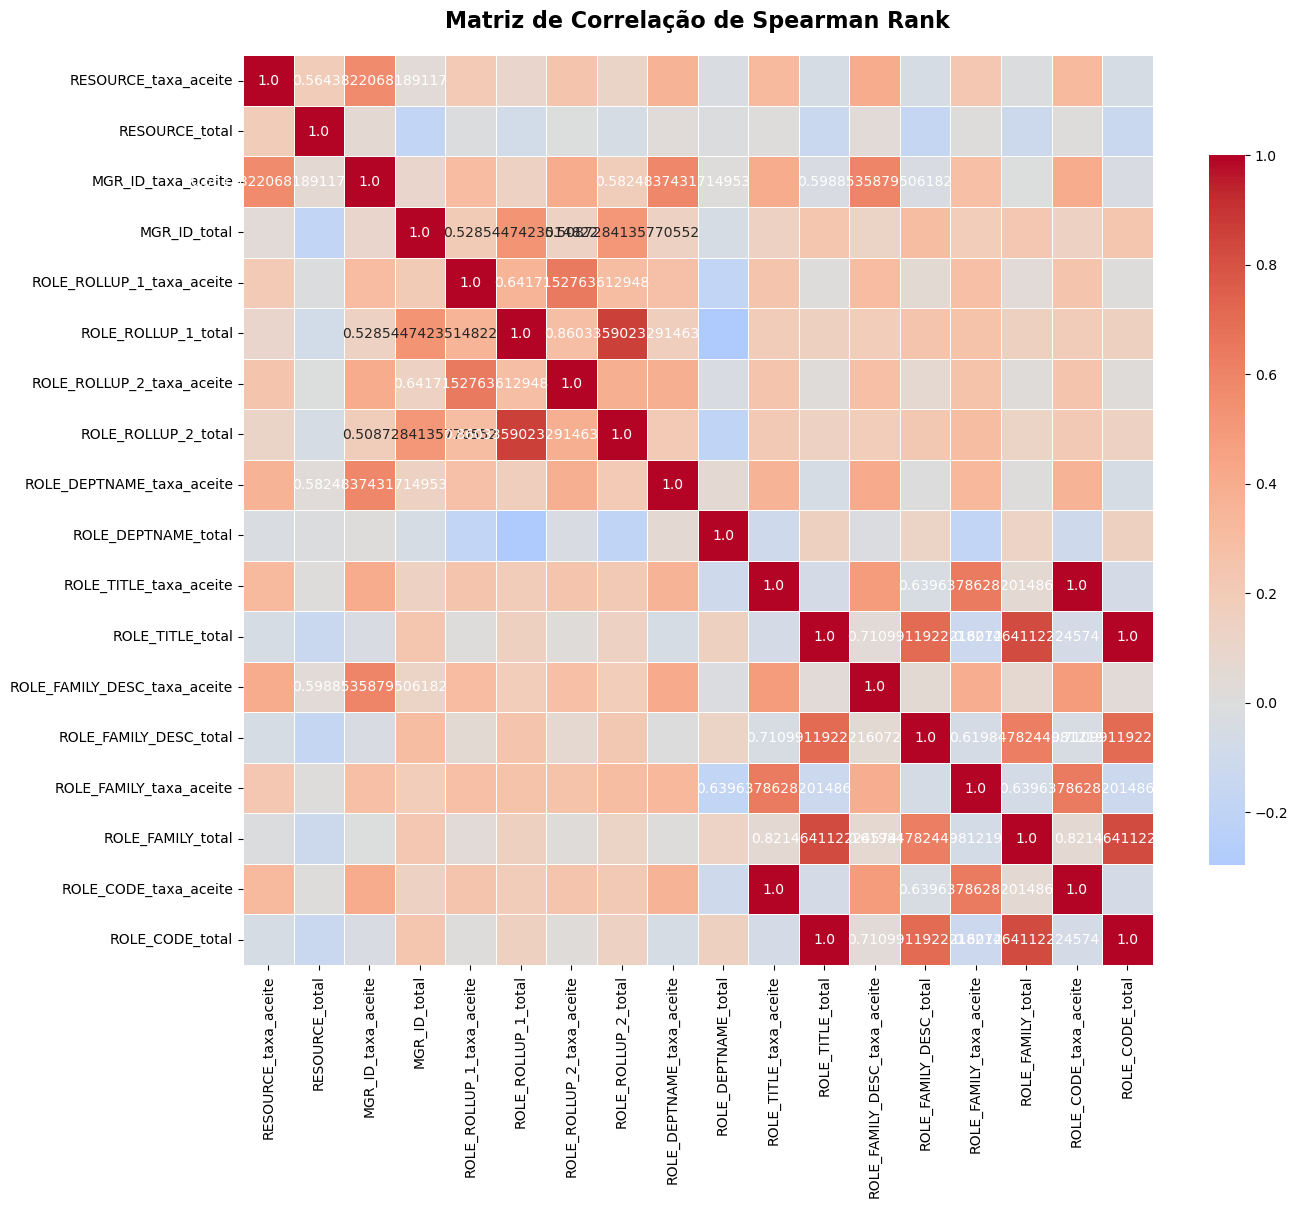

In [72]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate Spearman's correlation matrix
spearman_corr = X_resampled.corr(method='spearman')

print("Spearman Correlation Matrix Shape:", spearman_corr.shape)
print("\nSpearman Correlation Matrix (first 5x5):")
print(spearman_corr.iloc[:5, :5])

# Create a custom annotation matrix (only show strong correlations)
threshold = 0.5  # Only annotate correlations above this threshold
annot_matrix = spearman_corr.copy()
annot_matrix = annot_matrix.where(abs(annot_matrix) > threshold, "")


# Create heatmap
plt.figure(figsize=(14, 12))
# sns.heatmap(spearman_corr, 
#             annot=True,
#             fmt='.2f',
#             cmap='coolwarm',
#             center=0,
#             square=True,
#             linewidths=0.5,
#             cbar_kws={"shrink": 0.75})


# Create heatmap
sns.heatmap(spearman_corr,
            annot=annot_matrix,      # Custom annotations
            fmt='',                  # No format for empty strings
            cmap='coolwarm',
            center=0,
            square=True,
            linewidths=0.5,
            cbar_kws={"shrink": 0.75})



plt.title('Matriz de Correlação de Spearman Rank', 
          fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Aplicação dos Modelos ML

## Knn

In [39]:
from sklearn.neighbors import KNeighborsClassifier

# Treinando modelo Knn

X_train, X_test, y_train, y_test = train_test_split(
    X_resampled,
    y_resampled,
    test_size=0.2,
    random_state=42,
    stratify=y_resampled   # IMPORTANT for classification
)


knn = KNeighborsClassifier(
    n_neighbors=5,
    weights='distance',
    metric='euclidean'
)


knn.fit(X_train, y_train)

KNeighborsClassifier(metric='euclidean', weights='distance')

In [41]:
y_pred = knn.predict(X_test)
y_pred

array([0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0,
       1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0,
       0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1,
       0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1,
       0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0,
       1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1,
       0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1,

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

# Basic confusion matrix
cm = confusion_matrix(y_test, y_pred, normalize='true')
print("Confusion Matrix:")
print(cm)
print()

# Get classification report


Confusion Matrix:
[[0.88947368 0.11052632]
 [0.09762533 0.90237467]]



Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.89      0.90       380
           1       0.89      0.90      0.90       379

    accuracy                           0.90       759
   macro avg       0.90      0.90      0.90       759
weighted avg       0.90      0.90      0.90       759



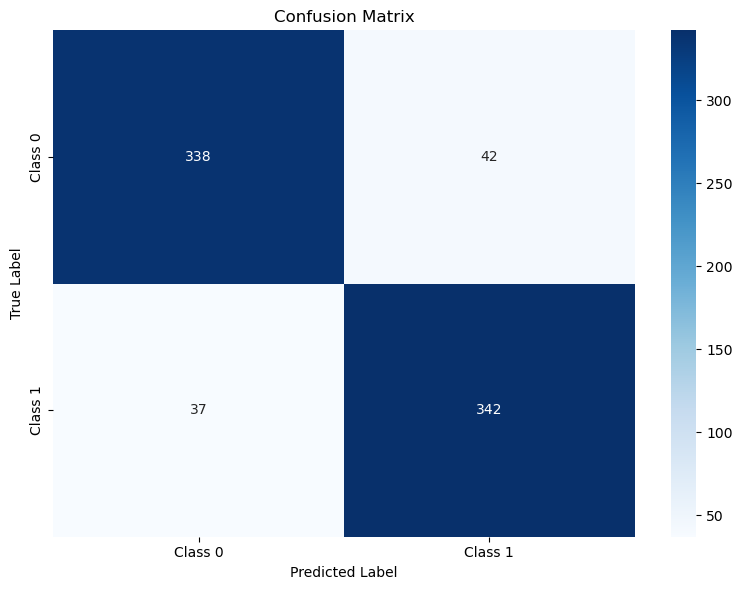

In [43]:
def plot_confusion_matrix(y_true, y_pred, classes=None, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    """
    Plot a confusion matrix.
    
    Parameters:
    y_true: True labels
    y_pred: Predicted labels
    classes: List of class names
    normalize: Whether to normalize the matrix
    title: Plot title
    cmap: Color map
    """
    cm = confusion_matrix(y_true, y_pred)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fmt = '.2f'
    else:
        fmt = 'd'
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt=fmt, cmap=cmap,
                xticklabels=classes, yticklabels=classes)
    
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()



print("Classification Report:")
print(classification_report(y_test, y_pred))

# Example with binary classification
plot_confusion_matrix(y_test, y_pred, classes=['Class 0', 'Class 1'])

## Random Forest

Random Forest - Confusion Matrix:
[[367  13]
 [ 35 344]]

Random Forest - Normalized Confusion Matrix:
[[0.96578947 0.03421053]
 [0.09234828 0.90765172]]

Random Forest - Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94       380
           1       0.96      0.91      0.93       379

    accuracy                           0.94       759
   macro avg       0.94      0.94      0.94       759
weighted avg       0.94      0.94      0.94       759


Random Forest - Standard Confusion Matrix:


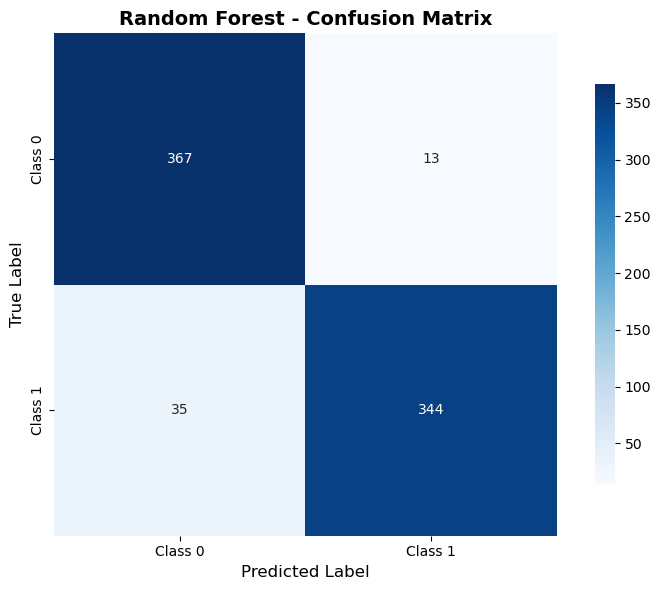


Random Forest - Normalized Confusion Matrix:


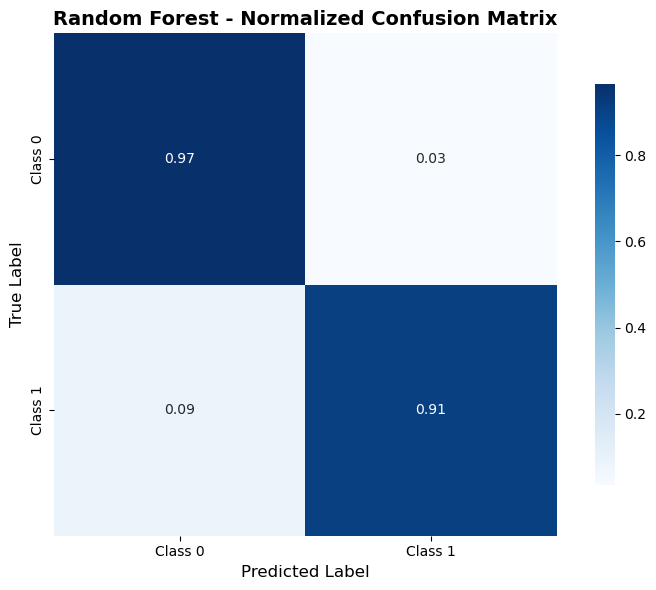

Random Forest Performance Metrics:
----------------------------------------
Accuracy: 0.9368
Precision: 0.9636
Recall: 0.9077
F1-Score: 0.9348
ROC-AUC: 0.9762

MODEL COMPARISON

Random Forest Training Score: 1.0000
Random Forest Test Score: 0.9368
Difference (Train - Test): 0.0632

Cross-validation scores (5-fold): [0.94729908 0.96310935 0.9486166  0.93807642 0.94722955]
Mean CV accuracy: 0.9489
CV accuracy std: 0.0081

Random Forest - ROC Curve:


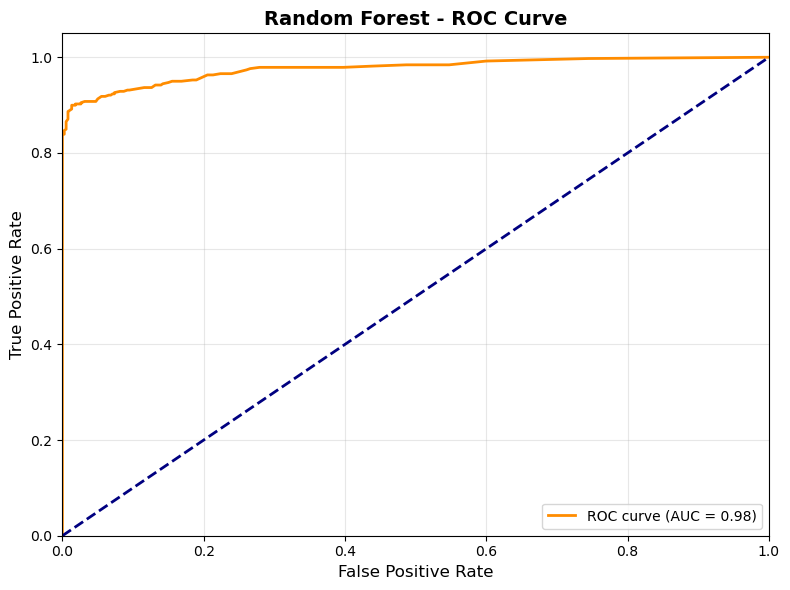


Random Forest - Precision-Recall Curve:


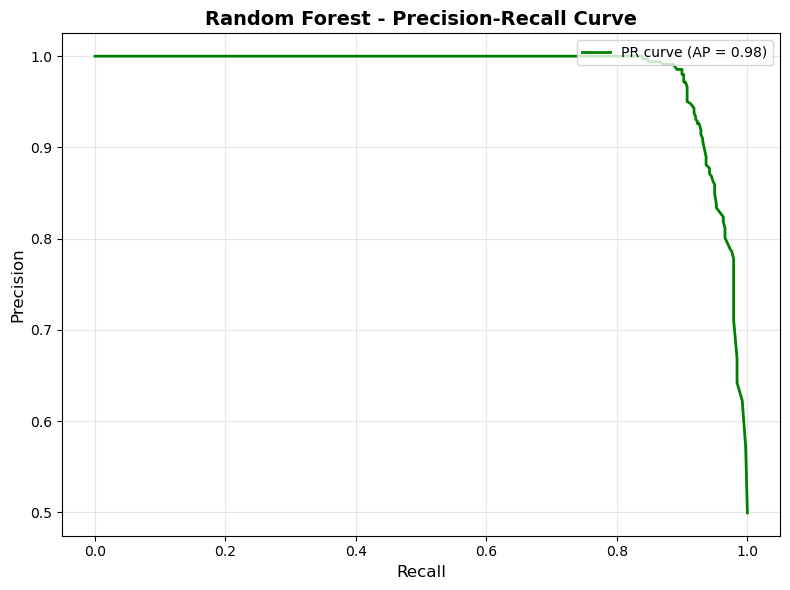

In [44]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming X_resampled and y_resampled are already defined from your previous code

# Splitting the data (same parameters as KNN)
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled,
    y_resampled,
    test_size=0.2,
    random_state=42,
    stratify=y_resampled   # IMPORTANT for classification
)

# Training Random Forest model
rf = RandomForestClassifier(
    n_estimators=100,        # Number of trees in the forest
    max_depth=None,          # Maximum depth of each tree
    min_samples_split=2,     # Minimum samples required to split a node
    min_samples_leaf=1,      # Minimum samples required at a leaf node
    max_features='sqrt',     # Number of features to consider for best split
    random_state=42,
    n_jobs=-1                # Use all available processors
)

# Fit the model
rf.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf.predict(X_test)

# Get predicted probabilities (useful for ROC curve, precision-recall curve)
y_pred_proba_rf = rf.predict_proba(X_test)[:, 1]  # Probability of positive class

# Basic confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
print("Random Forest - Confusion Matrix:")
print(cm_rf)
print()

# Normalized confusion matrix
cm_rf_norm = confusion_matrix(y_test, y_pred_rf, normalize='true')
print("Random Forest - Normalized Confusion Matrix:")
print(cm_rf_norm)
print()

# Classification report
print("Random Forest - Classification Report:")
print(classification_report(y_test, y_pred_rf))

# Function to plot confusion matrix (same as before)
def plot_confusion_matrix(y_true, y_pred, classes=None, normalize=False, 
                          title='Confusion Matrix', cmap=plt.cm.Blues):
    """
    Plot a confusion matrix.
    
    Parameters:
    y_true: True labels
    y_pred: Predicted labels
    classes: List of class names
    normalize: Whether to normalize the matrix
    title: Plot title
    cmap: Color map
    """
    cm = confusion_matrix(y_true, y_pred)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fmt = '.2f'
    else:
        fmt = 'd'
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt=fmt, cmap=cmap,
                xticklabels=classes, yticklabels=classes,
                square=True, cbar_kws={"shrink": 0.8})
    
    plt.title(title, fontsize=14, fontweight='bold')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    plt.show()

# Plot confusion matrices for Random Forest
print("\nRandom Forest - Standard Confusion Matrix:")
plot_confusion_matrix(y_test, y_pred_rf, 
                      classes=['Class 0', 'Class 1'],
                      title='Random Forest - Confusion Matrix')

print("\nRandom Forest - Normalized Confusion Matrix:")
plot_confusion_matrix(y_test, y_pred_rf, 
                      classes=['Class 0', 'Class 1'],
                      normalize=True,
                      title='Random Forest - Normalized Confusion Matrix')

# Additional useful metrics and visualizations for Random Forest

# 1. Feature Importance
def plot_feature_importance(model, feature_names=None):
    """
    Plot feature importance for tree-based models.
    """
    importances = model.feature_importances_
    
    if feature_names is None:
        feature_names = [f'Feature {i}' for i in range(len(importances))]
    
    # Sort features by importance
    indices = np.argsort(importances)[::-1]
    
    plt.figure(figsize=(10, 6))
    plt.title("Random Forest - Feature Importances", fontsize=14, fontweight='bold')
    plt.bar(range(len(importances)), importances[indices], align="center")
    plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
    plt.xlim([-1, len(importances)])
    plt.tight_layout()
    plt.show()
    
    # Print top features
    print("Top 10 Most Important Features:")
    for i in range(min(10, len(indices))):
        print(f"{i+1}. {feature_names[indices[i]]}: {importances[indices[i]]:.4f}")

# If you have feature names, pass them here:
# plot_feature_importance(rf, feature_names=your_feature_names)

# 2. Model performance metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def calculate_metrics(y_true, y_pred, y_pred_proba=None):
    """
    Calculate and print various performance metrics.
    """
    metrics = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred, average='binary'),
        'Recall': recall_score(y_true, y_pred, average='binary'),
        'F1-Score': f1_score(y_true, y_pred, average='binary')
    }
    
    if y_pred_proba is not None:
        metrics['ROC-AUC'] = roc_auc_score(y_true, y_pred_proba)
    
    print("Random Forest Performance Metrics:")
    print("-" * 40)
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")
    
    return metrics

# Calculate metrics for Random Forest
rf_metrics = calculate_metrics(y_test, y_pred_rf, y_pred_proba_rf)

# 3. Compare with KNN (if you want to compare both models)
print("\n" + "="*50)
print("MODEL COMPARISON")
print("="*50)

# Assuming you have y_pred_knn from your KNN model
# knn_metrics = calculate_metrics(y_test, y_pred, y_pred_proba_knn)

# 4. Training scores (to check for overfitting)
train_score = rf.score(X_train, y_train)
test_score = rf.score(X_test, y_test)

print(f"\nRandom Forest Training Score: {train_score:.4f}")
print(f"Random Forest Test Score: {test_score:.4f}")
print(f"Difference (Train - Test): {train_score - test_score:.4f}")

# 5. Cross-validation for more reliable performance estimate
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(rf, X_resampled, y_resampled, 
                           cv=5, scoring='accuracy', n_jobs=-1)

print(f"\nCross-validation scores (5-fold): {cv_scores}")
print(f"Mean CV accuracy: {cv_scores.mean():.4f}")
print(f"CV accuracy std: {cv_scores.std():.4f}")

# 6. ROC Curve
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_true, y_pred_proba, model_name='Model'):
    """
    Plot ROC curve.
    """
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(f'{model_name} - ROC Curve', fontsize=14, fontweight='bold')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

print("\nRandom Forest - ROC Curve:")
plot_roc_curve(y_test, y_pred_proba_rf, 'Random Forest')

# 7. Precision-Recall Curve (especially useful for imbalanced datasets)
from sklearn.metrics import precision_recall_curve, average_precision_score

def plot_pr_curve(y_true, y_pred_proba, model_name='Model'):
    """
    Plot Precision-Recall curve.
    """
    precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
    avg_precision = average_precision_score(y_true, y_pred_proba)
    
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='green', lw=2,
             label=f'PR curve (AP = {avg_precision:.2f})')
    plt.xlabel('Recall', fontsize=12)
    plt.ylabel('Precision', fontsize=12)
    plt.title(f'{model_name} - Precision-Recall Curve', fontsize=14, fontweight='bold')
    plt.legend(loc="upper right")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

print("\nRandom Forest - Precision-Recall Curve:")
plot_pr_curve(y_test, y_pred_proba_rf, 'Random Forest')

## Rede Neural

C:\Users\balad\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Confusion Matrix:
[[349  31]
 [ 41 338]]

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.92      0.91       380
           1       0.92      0.89      0.90       379

    accuracy                           0.91       759
   macro avg       0.91      0.91      0.91       759
weighted avg       0.91      0.91      0.91       759



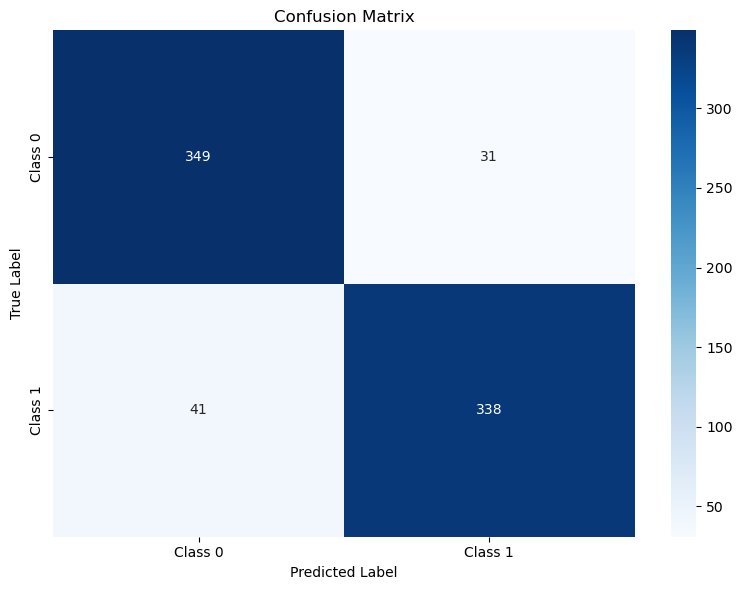

In [47]:
# Simplified TensorFlow version - similar to your KNN/RF structure

from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, precision_recall_curve, average_precision_score


import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix, classification_report

# Prepare data (same split as before)
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

# Standardize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Simple model
simple_model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(1, activation='sigmoid')  # For binary classification
])

# Compile
simple_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train
history = simple_model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=32,
    verbose=0
)

# Predict
y_pred_proba_simple = simple_model.predict(X_test_scaled)
y_pred_simple = (y_pred_proba_simple > 0.5).astype(int).flatten()

# Confusion Matrix
cm_simple = confusion_matrix(y_test, y_pred_simple)
print("Confusion Matrix:")
print(cm_simple)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_simple))

# Same confusion matrix plotting function as before
def plot_confusion_matrix(y_true, y_pred, classes=None, normalize=False, 
                          title='Confusion Matrix', cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fmt = '.2f'
    else:
        fmt = 'd'
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt=fmt, cmap=cmap,
                xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(y_test, y_pred_simple, classes=['Class 0', 'Class 1'])

In [288]:
import sys
!{sys.executable} -m pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable
